# Euler problem

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

## Постановка задачи

Задача Римана для одномерной нестационарной системы уравнений Эйлера прелставлеяет собой задачу Коши для законов сохранения

$$
\frac{\partial{\mathbf{U}}}{\partial{t}} + \frac{\partial{\mathbf{F}}}{\partial{x}} = 0, \\
\mathbf{U} = \begin{pmatrix}\rho \\ \rho u  \\E \end{pmatrix}, \;
\mathbf{F} = \begin{pmatrix}\rho u \\ \rho u^2+p  \\ u(E+p) \end{pmatrix}
$$

с начальными условиями

$$
\mathbf{U}(x,0)=\mathbf{U}^{(0)}(x) = 
\begin{cases}
\mathbf{U}_L ~\textrm{если} ~ x<0 \\
\mathbf{U}_R ~\textrm{если} ~ x>0
\end{cases}
$$

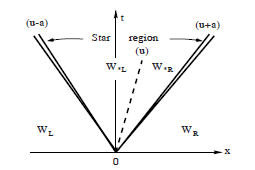

Система уравнений замыкается уравнением состояния

$$
e = \frac{p}{(\gamma -1) \rho}
$$

## Уравнения для давления и скорости

Согласно Торо, значение давления в интересующей нас области это корень алгебраического уравнения:

\begin{equation}
f(p,\mathbf{W}_L,\mathbf{W}_R) \equiv f_L(p,\mathbf{W}_L) +f_R(p,\mathbf{W}_R) + \Delta u = 0, ~ \Delta u \equiv u_R - u_L,
\end{equation}

где функция $f_L$ задается соотношением

\begin{equation}
f_L(p,\mathbf{W}_L) = 
\left \{ 
\begin{array}{ll}
(p-p_L)\left[ \frac{A_L}{p+B_L} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_L ~(скачок),& \\
\frac{2c_L}{(\gamma-1)}\left[ \left(\frac{p}{p_L} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_L ~(разрежение),&
\end{array}
\right .
\end{equation}

функция $f_R$ задается соотношением

\begin{equation}
f_R(p,\mathbf{W}_R) = 
\left \{ 
\begin{array}{ll}
(p-p_R)\left[ \frac{A_R}{p+B_R} \right]^\frac{1}{2} &~\textrm{если} ~ p>p_R ~(скачок),& \\
\frac{2c_R}{(\gamma-1)}\left[ \left(\frac{p}{p_R} \right)^\frac{\gamma-1}{2\gamma} -1 \right] &~\textrm{если} ~p\leq p_R ~(разрежение),&
\end{array}
\right .
\end{equation}

а константы $A_L,~B_L,~A_R,~B_R$ задаются как

\begin{equation}
\left .
\begin{array}{ll}
A_L = \frac{2}{(\gamma+1)\rho_L},~B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
A_R = \frac{2}{(\gamma+1)\rho_R},~B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R.
\end{array}
\right \}
\end{equation}

Скорость вычисляется из соотношения
\begin{equation}
u_*=\frac{1}{2}(u_L+u_R) + \frac{1}{2}[f_R(p_*) - f_L(p_*)].
\end{equation}

In [2]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  
tol = 1e-8

In [3]:
def sound_speed(d, p):
    return (gamma * p / d)**0.5

In [4]:
def calc_f(p, d_k, u_k, p_k):
    c_k = sound_speed(d_k, p_k)
    if p > p_k:
        A = g_p_1_over_2_inv / d_k
        B = g_m_1_over_g_p_1 * p_k
        f = (p - p_k) * (A / (p + B))**0.5
        f_deriv = (A / (p + B))**0.5*(1 - 0.5 * (p - p_k) / (p + B))
    else :
        f = g_m_1_over_2_inv * c_k * ((p / p_k)**g_m_1_over_2g - 1)
        f_deriv = c_k / (p * g_m_1) * ((2 * gamma - 1) / gamma * (p / p_k)**g_m_1_over_2g - 1)
    return f, f_deriv

## guess p

- Two Rarefaction (TR):
$$ p_{TR} =  \left[ \frac{c_R + c_L - \frac{1}{2}(\gamma - 1)(u_R - u_L)}{c_L / p_L^{\frac{\gamma - 1}{2\gamma}} + c_R /p_R^{\frac{\gamma - 1}{2\gamma}}} \right]^ {\frac{2\gamma}{\gamma - 1}}$$


- Primitive Variables (PV):
 $$
 \begin{cases}
 p_{PV} = \frac{1}{2}(p_L + p_R) - \frac{1}{8} (u_R - u_L)(\rho_L + \rho_R)(c_L + c_R)\\
 p_0 = max(TOL, p_{PV})
 \end{cases}$$
 
 
- Two Shock (TS):
 $$
 \begin{cases}
 p_{TS} = \frac{g_L(\hat{p}) p_L + g_R(\hat{p}) p_R  - \Delta u} {g_L(\hat{p}) + g_R(\hat{p})} \\
 g_K = (\frac{A_K}{p + B_K})^{\frac{1}{2}} \\
 p_0 = max(TOL, p_{TS})
 \end{cases}$$

In [5]:
def guess_p(W_l, W_r, label):
    c_l = sound_speed(W_l[0],W_l[2])
    c_r = sound_speed(W_r[0],W_r[2])
    W_aver = 0.5 * (W_l + W_r)
    p_pv = W_aver[2] - 0.5 * (W_r[1] - W_l[1]) * W_aver[0] * 0.5 * (c_l + c_r)
    if label == 'TR':
        return ((c_l + c_r - 0.5*g_m_1*(W_r[1] - W_l[1]))/
                ((c_l/W_l[2]**g_m_1_over_2g) + (c_r/W_r[2]**g_m_1_over_2g) ))**g_m_1_over_2g_inv
    elif label == 'PV':  
        p_0 = max(tol, p_pv)
        return p_0
    elif label == 'TS':
        A_k = lambda x : g_p_1_over_2_inv / x
        B_k = lambda x : g_m_1_over_g_p_1 * x
        g_L = (A_k(W_l[0]) / (p_pv + B_k(W_l[2])))**0.5
        g_R = (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5
        p_ts = (g_L * W_l[2] + g_R * W_r[2] - (W_r[1]-W_l[1])) / (g_L + g_R)
        p_0 = max(tol, p_ts)
        return p_0
    else:
        return W_aver[2] 

In [6]:
def init(case):
    if case == 'sod':
        W_l = np.array([1, 0.75, 1])
        W_r = np.array([0.125, 0, 0.1])
        t = 0.25
    elif case == '123':
        W_l = np.array([1, -2, 0.4])
        W_r = np.array([1, 2, 0.4])
        t = 0.15
    elif case == 'left-woodward':
        W_l = np.array([1, 0, 1000])
        W_r = np.array([1, 0, 0.1])
        t = 0.012
    else : print('Unknown case!')
    return W_l, W_r, t

In [7]:
W_l,W_r,_ = init('sod')

In [8]:
def newton(p_init, W_l, W_r):
    p_curr = p_init
    cha =1e3
    i= 0
    while cha > tol:
        f_l = calc_f(p_curr,*W_l)
        f_r = calc_f(p_curr,*W_r)
        p_new = p_curr - (f_l[0] + f_r[0] + W_r[1] - W_l[1]) / (f_l[1] + f_r[1])
        cha = abs(2 * (p_new - p_curr) / (p_new + p_curr))
        p_curr = p_new
        i = i+1
    u_new = 0.5 * (W_l + W_r)[1] + 0.5 * (calc_f(p_new,*W_r)[0] - calc_f(p_new,*W_l)[0])
    return p_new, u_new

In [9]:
def sample(W_l, c_l, W_r, c_r, p_star, u_star, s):
    """
    Returns d,u,p in sampled point according the shock and wave configuration
    """
    d_l, u_l, p_l = W_l #плотность, скорость, давление
    d_r, u_r, p_r = W_r
    #----------------------------------------------------------------------------------------------------
    if s <= u_star:              #точка лежит слева от контактного разрыва
        if p_star <= p_l: #слева -- волна разрежения
            S_HL = u_l - c_l   #скорость головной характеристики волны разрежения   
            if s <= S_HL: #точка лежит слева от волны -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:
                c_star_l = c_l * (p_star / p_l)**g_m_1_over_2g  #скорость звука справа от левой волны
                S_TL = u_star - c_star_l        #скорость замыкающей характеристики волны разрежения  
                if s>=S_TL:              #точка лежит между волной и контактным разрывом   
                    d = d_l * (p_star / p_l)**(1./gamma)
                    u = u_star
                    p = p_star
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv * (c_l + g_m_1_over_2 * u_l + s)
                    c = u - s
                    d = d_l*(c / c_l)**g_m_1_over_2_inv
                    p = p_l*(c / c_l)**g_m_1_over_2g_inv
        else:       #слева -- скачок 
            shock_ratio = p_star / p_l
            S_l = u_l - c_l * (g_p_1_over_2g * shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            if s <= S_l: #точка лежит слева от скачка -- все значения из левой ячейки
                d = d_l
                u = u_l
                p = p_l
            else:   #точка лежит между скачком и контактным разрывом
                d = d_l * (shock_ratio + (gamma - 1) / (gamma + 1))/((gamma - 1) / (gamma + 1) * shock_ratio + 1)
                u = u_star
                p = p_star 
    #----------------------------------------------------------------------------------------------------
    else:              #точка лежит справа от контактного разрыва
        if p_star > p_r:   #справа -- скачок
            shock_ratio = p_star / p_r
            S_r = u_r + c_r * (g_p_1_over_2g * shock_ratio + g_m_1_over_2g)**0.5 #скорость скачка
            if s >= S_r: #точка лежит справа от скачка -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:   #точка лежит между скачком и контактным разрывом
                d = d_r * (shock_ratio + g_m_1_over_g_p_1) / (g_m_1_over_g_p_1 * shock_ratio + 1)
                u = u_star
                p = p_star
        else:           #справа -- волна
            S_HR = u_r + c_r   #скорость головной характеристики волны разрежения
            if s >= S_HR: #точка лежит справа от волны -- все значения из правой ячейки
                d = d_r
                u = u_r
                p = p_r
            else:
                c_star_r = c_r * (p_star / p_r)**g_m_1_over_2g #скорость звука слева от правой волны
                S_TR = u_star + c_star_r           #скорость замыкающей характеристики волны разрежения
                if s <= S_TR:              #точка лежит между контактным разрывом и волной
                    d = d_r * (p_star / p_r)**(1 / gamma)
                    u = u_star
                    p = p_star
                else:                              #точка лежит в веере волны разрежения
                    u = g_p_1_over_2_inv * (-c_r + g_m_1_over_2 * u_r + s)
                    c = -u + s
                    d = d_r * (c / c_r)**g_m_1_over_2_inv
                    p = p_r * (c / c_r)**g_m_1_over_2g_inv
    return d, u, p

In [10]:
def get_S_max(W_l, c_l, W_r, c_r, p_star, u_star):
    d_l, u_l, p_l = W_l
    d_r, u_r, p_r = W_r
    if p_star <= p_l: #слева -- волна разрежения
        S_l = u_l - c_l
    else:
        shock_ratio = p_star / p_l
        S_l = u_l - c_l * (g_p_1_over_2g * shock_ratio + g_m_1_over_2g)**0.5
    if p_star > p_r:
        shock_ratio = p_star / p_r
        S_r = u_r + c_r*(g_p_1_over_2g*shock_ratio + g_m_1_over_2g)**0.5 
    else:
        S_r = u_r + c_r
    S_max = max(abs(S_l), abs(S_r))
    return S_max

In [11]:
N_points = 101
x = np.linspace(0, 1, N_points)
decay_pos = 0.3
W_correct= np.zeros((N_points,3))

In [12]:
W_l, W_r, t = init('sod')
p_init = guess_p(W_l, W_r, 'TR')
p_star, u_star = newton(p_init, W_l, W_r)

In [13]:
c_l = sound_speed(W_l[0], W_l[2])
c_r = sound_speed(W_r[0], W_r[2])
for i, x_ in enumerate(x):
    s = (x_ - decay_pos) / t
    W_correct[i] = np.asarray(sample(W_l, c_l, W_r, c_r, p_star, u_star, s))

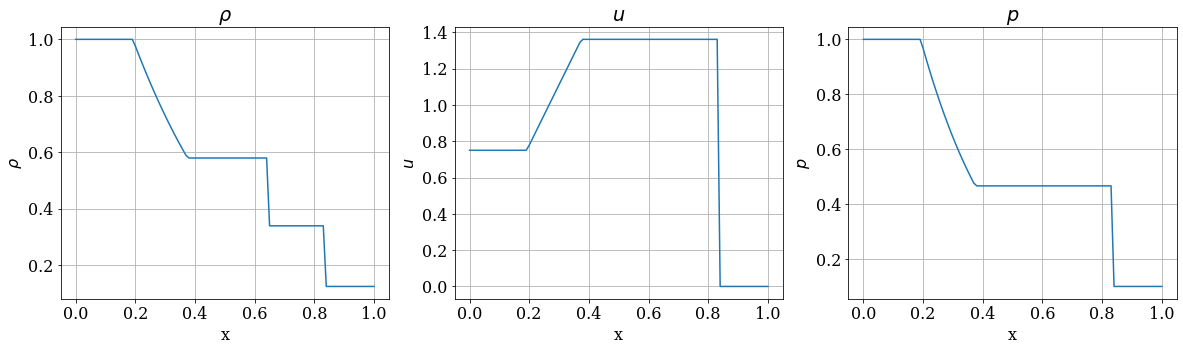

In [14]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
for ax,W_,y_label in zip(axs,W_correct.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_)
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.set_title(y_label)
    ax.grid()

In [15]:
%store W_correct

Stored 'W_correct' (ndarray)


In [16]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1] / U[0]
    W[2] = g_m_1 * (U[2] - 0.5 * U[1]**2 / U[0])
    return W

In [17]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1] * W[0]
    U[2] = 0.5 * W[1]**2 * W[0] + W[2] / g_m_1
    return U

In [18]:
def flux(W):
    F = np.zeros_like(W)
    F[0] = W[1] * W[0]
    F[1] = W[1]**2 * W[0] + W[2]
    F[2] = W[1] * (0.5 * W[1]**2 * W[0] + W[2] / g_m_1 + W[2])
    return F

In [19]:
dx = 1./(N_points - 1)
sigma = 1.
W = np.zeros((N_points,3))
fluxes = np.zeros((N_points - 1,3))
U = np.zeros_like(W)

In [20]:
W[np.where(x < decay_pos),:] = W_l
W[np.where(x >= decay_pos),:] = W_r

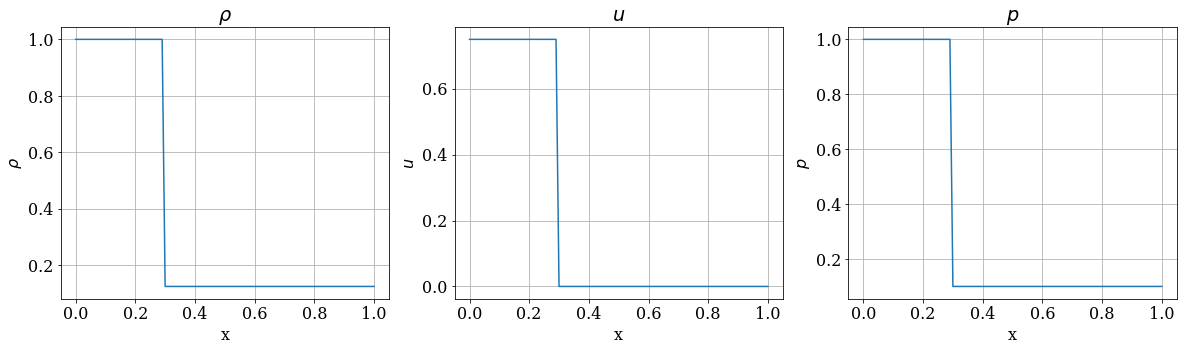

In [21]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
for ax,W_,y_label in zip(axs,W.T,(r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_)
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.set_title(y_label)
    ax.grid()

In [22]:
t_ = 0
U_n = np.copy(U)
while t_< t:
    U = W_to_U(W.T).T
    big_values = np.zeros((N_points - 1,3))
    speeds = np.zeros(N_points - 1)
    for i,x_ in enumerate(x[:-1]):
        p_init = guess_p(W[i], W[i+1],'TR')
        p_star, u_star = newton(p_init, W[i], W[i+1])
        c_l = sound_speed(W[i][0], W[i][2])
        c_r = sound_speed(W[i+1][0], W[i+1][2])
        s = 0
        big_values[i] = np.asarray(sample(W[i], c_l, W[i+1], c_r, p_star, u_star, s))
        speeds[i] = get_S_max(W[i], c_l, W[i+1], c_r, p_star, u_star)
    fluxes = flux(big_values.T).T
    dt = sigma * dx / max(speeds)
    U_n[1:-1,:] = U[1:-1,:] + dt / dx * (fluxes[:-1,:] - fluxes[1:,:]) 
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    W = U_to_W(U_n.T).T
    t_= t_ + dt

In [23]:
W_g = W.copy()
%store W_g

Stored 'W_g' (ndarray)


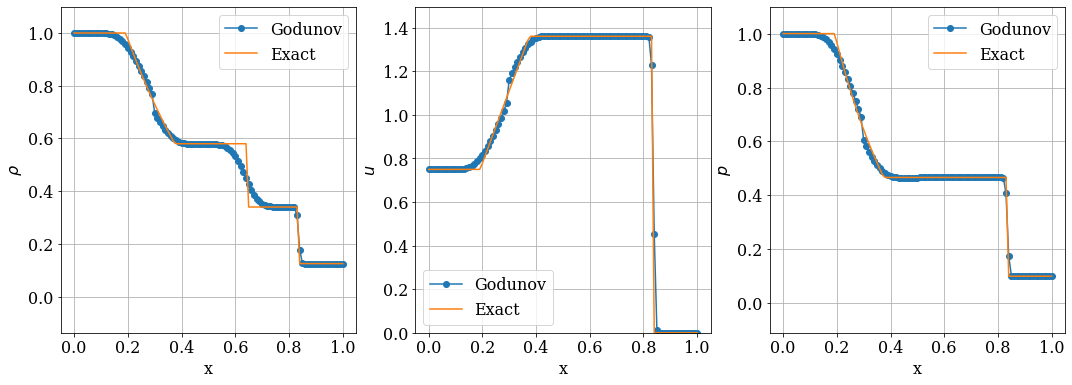

In [24]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
for ax, W_, W_c, y_label in zip(axs, W_g.T, W_correct.T, (r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x, W_,'-o', label='Godunov')
    ax.plot(x, W_c,label='Exact')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.set_ylim(-1.1*abs(min(W_c)),1.1*max(W_c))
    ax.legend(loc='best')
    ax.grid()

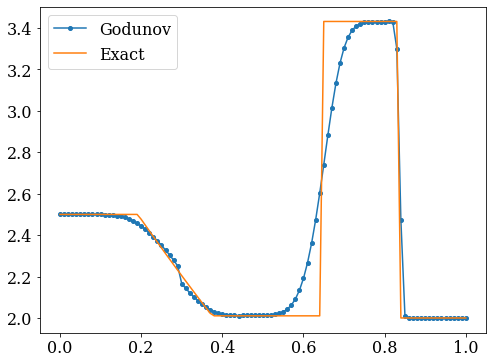

In [25]:
plt.figure(figsize=(8,6))
e = W[:,2] / W[:,0] / g_m_1
e_ex = W_correct[:,2] / W_correct[:,0] / g_m_1
plt.plot(x, e,'-o',label='Godunov', ms=4)
plt.plot(x, e_ex,'-',label='Exact')
plt.legend();